In [5]:
%load_ext watermark
%watermark  -d -u -a 'Andreas Mueller, Kyle Kastner, Sebastian Raschka' -v -p numpy,scipy,matplotlib

UsageError: unrecognized arguments: Mueller, Kyle Kastner, Sebastian Raschka'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# SciPy 2016 Scikit-learn Tutorial

Training and Testing Data
=====================================

To evaluate how well our supervised models generalize, we can split our data into a training and a test set:

<img src="figures/train_test_split_matrix.svg" width="100%">

In [1]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

iris = load_iris()
X, y = iris.data, iris.target

classifier = KNeighborsClassifier()

Thinking about how machine learning is normally performed, the idea of a train/test split makes sense. Real world systems train on the data they have, and as other data comes in (from customers, sensors, or other sources) the classifier that was trained must predict on fundamentally *new* data. We can simulate this during training using a train/test split - the test data is a simulation of "future data" which will come into the system during production. 

Specifically for iris, the 150 labels in iris are sorted, which means that if we split the data using a proportional split, this will result in fudamentally altered class distributions. For instance, if we'd perform a common 2/3 training data and 1/3 test data split, our training dataset will only consists of flower classes 0 and 1 (Setosa and Versicolor), and our test set will only contain samples with class label 2 (Virginica flowers).

Under the assumption that all samples are independent of each other (in contrast time series data), we want to **randomly shuffle the dataset before we split the dataset** as illustrated above.

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Now we need to split the data into training and testing. Luckily, this is a common pattern in machine learning and scikit-learn has a pre-built function to split data into training and testing sets for you. Here, we use 50% of the data as training, and 50% testing. 80% and 20% is another common split, but there are no hard and fast rules. The most important thing is to fairly evaluate your system on data it *has not* seen during training!

In [3]:
from sklearn.cross_validation import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.5, 
                                                    random_state=123)
print("Labels for training and testing data")
print(train_y)
print(test_y)

Labels for training and testing data
[1 1 0 2 2 0 0 1 1 2 0 0 1 0 1 2 0 2 0 0 1 0 0 1 2 1 1 1 0 0 1 2 0 0 1 1 1
 2 1 1 1 2 0 0 1 2 2 2 2 0 1 0 1 1 0 1 2 1 2 2 0 1 0 2 2 1 1 2 2 1 0 1 1 2
 2]
[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 2 0 2 0 0 0 2 2 0 2 2 0 0 1 1 2
 0 0 1 1 0 2 2 2 2 2 1 0 0 2 0 0 1 1 1 1 2 1 2 0 2 1 0 0 2 1 2 2 0 1 1 2 0
 2]


---

**Tip: Stratified Split**

Especially for relatively small datasets, it's better to stratify the split. Stratification means that we maintain the original class proportion of the dataset in the test and training sets. For example, after we randomly split the dataset as shown in the previous code example, we have the following class proportions in percent:

In [7]:
print('All:', np.bincount(y) / float(len(y)) * 100.0)
print('Training:', np.bincount(train_y) / float(len(train_y)) * 100.0)
print('Test:', np.bincount(test_y) / float(len(test_y)) * 100.0)

All: [ 33.33333333  33.33333333  33.33333333]
Training: [ 30.66666667  40.          29.33333333]
Test: [ 36.          26.66666667  37.33333333]


So, in order to stratify the split, we can pass the label array as an additional option to the `train_test_split` function:

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.5, 
                                                    random_state=123,
                                                    stratify=y)

print('All:', np.bincount(y) / float(len(y)) * 100.0)
print('Training:', np.bincount(train_y) / float(len(train_y)) * 100.0)
print('Test:', np.bincount(test_y) / float(len(test_y)) * 100.0)

All: [ 33.33333333  33.33333333  33.33333333]
Training: [ 33.33333333  33.33333333  33.33333333]
Test: [ 33.33333333  33.33333333  33.33333333]


---

By evaluating our classifier performance on data that has been seen during training, we could get false confidence in the predictive power of our model. In the worst case, it may simply memorize the training samples but completely fails classifying new, similar samples -- we really don't want to put such a system into production!

Instead of using the same dataset for training and testing (this is called "resubstitution evaluation"), it is much much better to use a train/test split in order to estimate how well your trained model is doing on new data.

In [9]:
classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)

print("Fraction Correct [Accuracy]:")
print(np.sum(pred_y == test_y) / float(len(test_y)))

Fraction Correct [Accuracy]:
0.96


We can also visualize the correct and failed predictions

In [10]:
print('Samples correctly classified:')
correct_idx = np.where(pred_y == test_y)[0]
print(correct_idx)

print('\nSamples incorrectly classified:')
incorrect_idx = np.where(pred_y != test_y)[0]
print(incorrect_idx)

Samples correctly classified:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 50 51
 52 53 54 55 56 57 58 59 61 62 63 64 65 66 67 68 69 70 71 72 73 74]

Samples incorrectly classified:
[44 49 60]


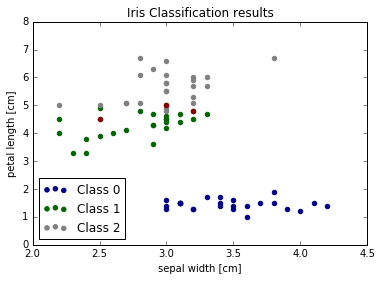

In [11]:
# Plot two dimensions

colors = ["darkblue", "darkgreen", "gray"]

for n, color in enumerate(colors):
    idx = np.where(test_y == n)[0]
    plt.scatter(test_X[idx, 1], test_X[idx, 2], color=color, label="Class %s" % str(n))

plt.scatter(test_X[incorrect_idx, 1], test_X[incorrect_idx, 2], color="darkred")

plt.xlabel('sepal width [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc=3)
plt.title("Iris Classification results")
plt.show()

We can see that the errors occur in the area where green (class 1) and gray (class 2) overlap. This gives us insight about what features to add - any feature which helps separate class 1 and class 2 should improve classifier performance.

# Exercise

Print the true labels of 3 wrong predictions and modify the scatterplot code, which we used above, to visualize and distinguish these three samples with different markers in the 2D scatterplot. Can you explain why our classifier made these wrong predictions?

44: Predicted 2 True label 1
49: Predicted 2 True label 1
60: Predicted 1 True label 2


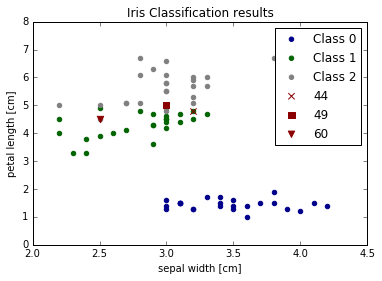

In [13]:
# %load solutions/04_wrong-predictions.py
for i in incorrect_idx:
    print('%d: Predicted %d True label %d' % (i, pred_y[i], test_y[i]))

# Plot two dimensions

colors = ["darkblue", "darkgreen", "gray"]

for n, color in enumerate(colors):
    idx = np.where(test_y == n)[0]
    plt.scatter(test_X[idx, 1], test_X[idx, 2],
                color=color, label="Class %s" % str(n))

for i, marker in zip(incorrect_idx, ['x', 's', 'v']):
    plt.scatter(test_X[i, 1], test_X[i, 2],
                color="darkred",
                marker=marker,
                s=40,
                label=i)

plt.xlabel('sepal width [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc=1, scatterpoints=1)
plt.title("Iris Classification results")
plt.show()
